In [1]:
using DrWatson
@quickactivate "dare"

using ReinforcementLearning
using IntervalSets
using LinearAlgebra
using ControlSystems
using CUDA
using DataFrames
using Plots

include(srcdir("nodeconstructor.jl"))

include(srcdir("env.jl"));

In [2]:
Base.@kwdef mutable struct PV_module
    I_0 = 2.0381e-10           # Diode seturation
    ni = 1.2                   # Diode ideality factor for Si-mono
    k = 1.3806e-23             # Boltzman constant
    q = 1.6022e-19             # Electron charge
    T_0 = 273                  # Temperature offset
    N_cell = 36                 # Number of cells
#     V_T = k*T/q                # thermal voltage
    
#     R_s = 0.45                 # Serial resistance
#     R_p = 310.0248             # Parallel resistance
    G_ref = 1000               # Irradiance at STC
    mu_sc = 1.3e-3             # Coefficient tempreture of short circuit current
    I_ph_ref = 3.11            # Phototcurrent at STC
    
end;

In [3]:
Base.@kwdef mutable struct PV_array
    pv_module::PV_module           # module parameters
    serial = 10
    parallel = 4
    connection = 's'
    
end;

ErrorException: invalid redefinition of constant PV_array

In [4]:
Test_PV = PV_module();

In [5]:
function get_I(self::PV_module, V, G, T)
    function I_photo(self::PV_module, G, T)
        dT = self.T_0 + T
        I_ph = G/self.G_ref*(self.I_ph_ref + self.mu_sc * dT)
        return I_ph
    end;

    function I_diode(self::PV_module, V, G, T)
        dT = self.T_0 + T
        V_T = self.k*dT/self.q
        I_d = self.I_0*(exp(V/(self.ni*self.N_cell*V_T))-1)
        return I_d
    end;
    
    I = I_photo(self, G, T) - I_diode(self, V, G, T)
    return I
end

get_I (generic function with 2 methods)

In [6]:
function get_V(self::PV_module, I, G, T)
    function I_photo(self::PV_module, G, T)
        dT = self.T_0 + T
        I_ph = G/self.G_ref*(self.I_ph_ref + self.mu_sc * dT)
        return I_ph
    end;
    
    I = maximum([0,I])
    res = (I_photo(self, G, T)-I)
    
    dT = self.T_0 + T
    V_T = self.k*dT/self.q
    
    if res <= 0
        V=0
    else
        V = self.ni*self.N_cell*V_T*(log((res)/self.I_0)+1)
    end
    
    return V
end

get_V (generic function with 2 methods)

In [7]:
function get_I_test(pv_arr::PV_array, V, G, T)

    self = pv_arr.pv_module
    function I_photo(self::PV_module, G, T)
        dT = self.T_0 + T
        I_ph = G/self.G_ref*(self.I_ph_ref + self.mu_sc * dT)
        return I_ph
    end;

    function I_diode(self::PV_module, V, G, T)
        dT = self.T_0 + T
        V_T = self.k*dT/self.q
        I_d = self.I_0*(exp(V/(self.ni*self.N_cell*pv_arr.serial*V_T))-1)
        return I_d
    end;
    
    I = (I_photo(self, G, T) - I_diode(self, V, G, T)) * pv_arr.parallel
    return I
end;

function get_V_test(pv_arr::PV_array, I, G, T)

    self = pv_arr.pv_module
    function I_photo(self::PV_module, G, T)
        dT = self.T_0 + T
        I_ph = G/self.G_ref*(self.I_ph_ref + self.mu_sc * dT)
        return I_ph
    end;
    
    I = maximum([0.0,I[1]])
    res = I_photo(self, G, T)-(I/pv_arr.parallel)
    
    dT = self.T_0 + T
    V_T = self.k*dT/self.q
    
    if res <= 0
        V=0
    else
        V = self.ni*self.N_cell*pv_arr.serial*V_T*(log((res)/self.I_0)+1)
    end
    
    return V
end;

pv_module = PV_module()

pv_array = PV_array(;pv_module);

In [8]:
v_test = 150

150

In [9]:
i_test = get_I_test(pv_array, v_test, 1000, 27)

13.999444539034302

In [48]:
i_test2 = 9.2

9.2

In [49]:
v_test2 = get_V_test(pv_array, i_test2, 1000, 27)

262.3934152029668

In [12]:
# i_d                        # Diode current
# v_d                        # Diode voltage
# i_0                        # Diode seturation
ni = 1.2                   # Diode ideality factor for Si-mono
k = 1.3806e-23             # Boltzman constant
q = 1.6022e-19             # Electron charge
T = 20                     # Cell temperature
N_cell = 36                # Number of cells
V_T = k*T/q                # thermal voltage

R_s = 0.45                 # 
R_p = 310.0248             # 
G_ref = 1000               # Irradiance at STC
mu_sc = 1.3e-3             # Coefficient tempreture of short circuit current
I_ph_ref = 3.11            # Phototcurrent at STC
I_0 = 2.0381e-10;

In [13]:
serial = 10

10

In [14]:
parallel = 4

4

In [15]:
G = collect(200:200:1000)

5-element Vector{Int64}:
  200
  400
  600
  800
 1000

In [16]:
T = 25

25

In [17]:
V = 0:1:500

0:1:500

In [18]:
dT = 273 + T
V_T = k*dT/q   
I_ph = G./G_ref*(I_ph_ref + mu_sc * dT).* ones(length(V))';

In [19]:
I_d = I_0*(exp.(V/(ni*N_cell*serial*V_T)).-1).*ones(5)';

In [20]:
I = (I_ph' - I_d) * parallel;

In [21]:
V_ = V.*ones(5)';

In [22]:
I_nn = I[I .>= zero(I)];

In [23]:
P = I .* V_;

In [24]:
labels = ["200 W/m^2" "400 W/m^2" "600 W/m^2" "800 W/m^2" "1000 W/m^2"];

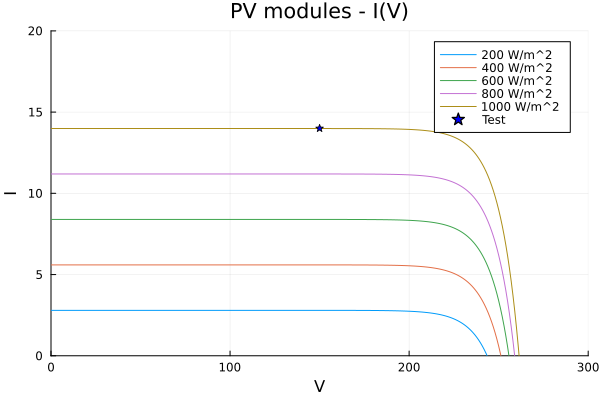

In [25]:
plot(V_, I, xlim=(0,300),ylim=(0,20),title="PV modules - I(V)", label=labels, xlabel="V", ylabel="I")
scatter!([v_test], [i_test], color="blue", markershape=:star5, label="Test")

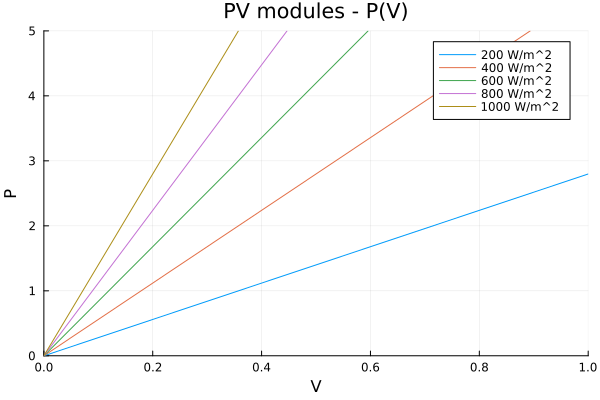

In [26]:
plot(V_, P, xlim=(0,1), ylim=(0,5),title="PV modules - P(V)", label=labels, xlabel="V", ylabel="P")

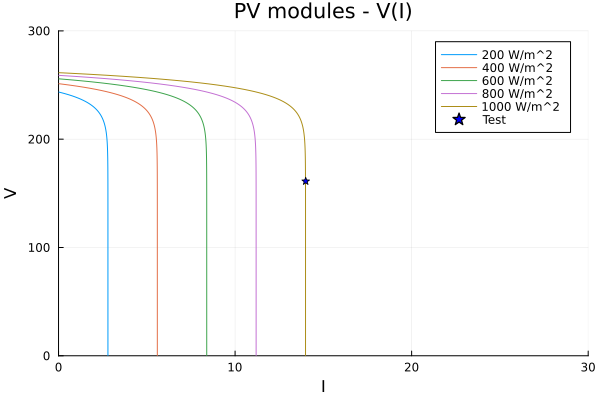

In [27]:
plot(I, V_, xlim=(0,30), ylim=(0,300),title="PV modules - V(I)", label=labels, xlabel="I", ylabel="V")
scatter!([i_test2],[v_test2], color="blue", markershape=:star5, label="Test")

In [28]:
[i_test2]

1-element Vector{Float64}:
 13.999444539034302

In [29]:
[v_test2]

1-element Vector{Float64}:
 161.1674882907313

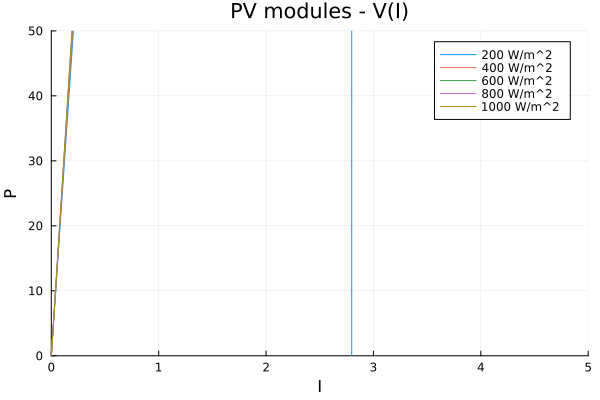

In [30]:
plot(I, P, xlim=(0,5), ylim=(0,50),title="PV modules - V(I)", label=labels, xlabel="I", ylabel="P")

## PV module V(I)

In [31]:
I_ph = G[5]./G_ref*(I_ph_ref + mu_sc * dT)
I = collect(0:0.001:3.497)
V = V_T*log.((I_ph.-I)/I_0)

3498-element Vector{Float64}:
 0.6051326217146304
 0.605125278534265
 0.6051179332533874
 0.6051105858707955
 0.6051032363852864
 0.6050958847956559
 0.6050885311006988
 0.6050811752992091
 0.6050738173899793
 0.6050664573718014
 ⋮
 0.4502524350185687
 0.44699765817223064
 0.4432696212060711
 0.43890689134466093
 0.4336481052070052
 0.4270274746518823
 0.4180835274425579
 0.4042429773529535
 0.37207406977694535

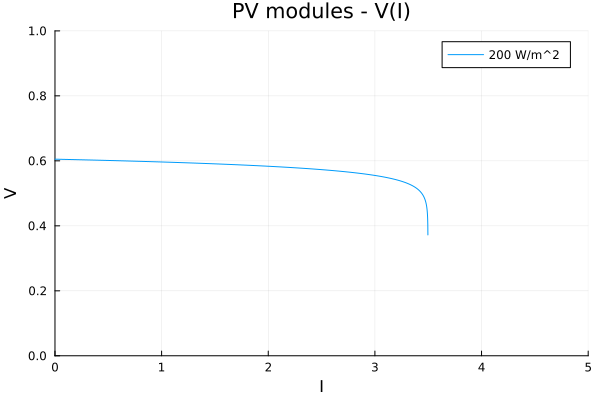

In [32]:
plot(I, V, xlim=(0,5), ylim=(0,1),title="PV modules - V(I)", label=labels, xlabel="I", ylabel="V")

## With R_s and R_p

In [33]:
dT = 273 + T
V_T = k*dT/q   
I_ph = G./G_ref*(I_ph_ref + mu_sc * dT)*ones(length(V))';
I_d = I_0*(exp.(V/(ni*N_cell*V_T)).-1).*ones(5)';

I_init = 1 .*ones(5)

R_s = 0.45                 # 
R_p = 310.0248             # 
        

function get_I(G, V)
    
    I_ph = ones(length(V)) * G/G_ref*(I_ph_ref + mu_sc * dT);
    delta = 0.00000000001
    
    function I_d(V, I)        
        a = ni*N_cell*V_T
        R_s = 0.45 
        return I_0*(exp.(V.+R_s.*I/(a)).-1)
    end

    function I_p(V, I)
        R_p = 310.0248
        R_s = 0.45 
        return V.+R_s.*I/R_p
    end
    
    function f_dot(V,I)
        a = ni*N_cell*V_T
        R_p = 310.0248
        R_s = 0.45 
        return -I_0*1/a*exp.(V.+R_s.*I/(a)).-1/R_p
    end
    
    I = 3*ones(length(V))
    I_= zeros(length(V))
    
    while true
        
        I_ = I - (I_ph - I_d(V,I) - I_p(V,I))./f_dot(V,I)
        
        check = sum(broadcast(abs, (I_-I)) .< delta)
        if check == length(V)
            break
        end
        I = I_
    end
            
    return I_
end
    

get_I (generic function with 3 methods)

In [34]:
V = 0:0.01:5

0.0:0.01:5.0

In [35]:
I =get_I(1000, V)

501-element Vector{Float64}:
    58.032633010766304
    58.00078226998045
    57.9689104633076
    57.937017467168815
    57.90510315689842
    57.87316740672828
    57.84121008977437
    57.80923107802335
    57.777230242319156
    57.74520745234929
     ⋮
  -980.0917342595865
  -986.9811742595863
  -993.8706142595869
 -1000.7600542595867
 -1007.6494942595866
 -1014.5389342595864
 -1021.4283742595868
 -1028.3178142595866
 -1035.2072542595865

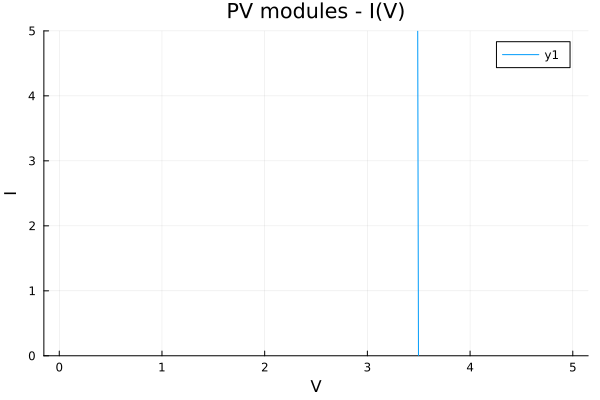

In [36]:
plot(V, I,ylim=(0,5),title="PV modules - I(V)", xlabel="V", ylabel="I")

In [37]:
V = 0:0.01:1

0.0:0.01:1.0

In [38]:
a = ni*N_cell*V_T
R_s = 0.45
R_p = 310.0248

310.0248

In [39]:
-I_0*1/a*exp.(V.+R_s.*I/(a)).-1/R_p

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 101 and 501

In [41]:
I_0*(exp.(V.+R_s.*I/(a)).-1)

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 101 and 501

In [42]:
sum(broadcast(abs, (I_-I)) .> delta)

UndefVarError: UndefVarError: I_ not defined

In [44]:
x=4

while true
    x_ = x - 3x^3/9x^2
    
    if abs(x_ - x) < 0.00001
        
        println(x_)
        break
    end
    x = x_
end

1.3906920135590839e-5
